In [30]:
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import json

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from keras import utils

utils.set_random_seed(42)

In [31]:
# Define Parameters
LOOKBACK = 24
HORIZON = 24
N_SPLITS = 4
BATCH_SIZE = 32
EPOCHS = 20
model_name='base'

In [33]:
with open('../../../config.json', 'r') as config_file:
    config = json.load(config_file)

df = pd.read_csv(os.path.join(config['data_path'], 'cell_multivar.csv'))

print(df.shape)
df.head()

(933661, 24)


,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionDur,blocks,...,Azimuth,SectorsPerBts,NearbyBts,Dist2Coast,ClusterId,CellsPerBts,OverallPageSessions,OverallULvol,OverallSessionDur,OverallBlocks
0,2023-09-02 00:30:00+00:00,580_0_0,580,0,0,-105.18,0,0.279611,23.411765,0,...,20.0,3.0,9.0,39.189340,0,3,243284,3278.715746,151645.970902,2
1,2023-09-02 00:30:00+00:00,580_2_0,580,2,0,-106.30,0,0.306054,22.725490,0,...,250.0,3.0,9.0,39.189340,0,3,398291,5039.146780,185577.046230,7
2,2023-09-02 00:30:00+00:00,580_2_1,580,2,1,-105.75,52,0.110888,26.846154,0,...,250.0,3.0,9.0,39.189340,0,3,149548,2538.938010,216524.383783,2
3,2023-09-02 00:30:00+00:00,579_2_1,579,2,1,-106.95,35,0.105287,8.975000,0,...,260.0,3.0,8.0,34.621906,0,1,224144,3234.243132,175408.135678,6
4,2023-09-02 00:30:00+00:00,564_2_1,564,2,1,-107.88,0,0.080681,20.050000,0,...,250.0,3.0,1.0,47.379122,0,2,154463,1777.783403,304683.070142,0


In [34]:
temporal_X = []
static_X = []

# Funcs

In [35]:
# Time series split function (Expanding Window)
def time_series_split(df, n_splits=N_SPLITS, test_size=0.2):
    df = df.sort_values('timestamp')
    test_split_index = int(len(df) * (1 - test_size))
    train_val_df = df.iloc[:test_split_index]
    test_df = df.iloc[test_split_index:]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = [(train_val_df.iloc[train_index], train_val_df.iloc[val_index]) for train_index, val_index in tscv.split(train_val_df)]
    return splits, test_df

In [36]:
# Sequence creation for univariate time series
def create_sequences(df, lookback=LOOKBACK, horizon=HORIZON):
    X, y, anomaly, cell_id = [], [], [], []

    # Loop through each unique cell in the dataset
    for cell in df['cell'].unique():
        # Filter the dataframe for the current cell only
        cell_df = df[df['cell'] == cell]

        # Generate sequences within this cell's data
        for i in range(lookback, len(cell_df) - horizon + 1):
            # Lookback sequence for minRSSI only (univariate)
            X_seq = cell_df.iloc[i - lookback:i][['minRSSI']].values
            # Target horizon sequence for minRSSI
            y_seq = cell_df.iloc[i:i + horizon]['minRSSI'].values
            # Anomaly sequences for later evaluation
            anomaly_seq = cell_df.iloc[i:i + horizon]['anomaly'].values
            # Cell ID for each sequence
            cell_seq = cell_df.iloc[i:i + horizon]['cell'].values

            # Append sequences to output lists
            X.append(X_seq)
            y.append(y_seq)
            anomaly.append(anomaly_seq)
            cell_id.append(cell_seq)

    # Convert lists to numpy arrays for model input
    return np.array(X), np.array(y), np.array(anomaly), np.array(cell_id)

In [37]:
def scale_data_split(train_df, val_df, temporal_features=temporal_X, static_features=static_X):
    scaler_temporal = StandardScaler()
    scaler_static = MinMaxScaler()
    scaler_target = StandardScaler()

    # Scale time-variant features
    if temporal_features:
        train_df[temporal_features] = scaler_temporal.fit_transform(train_df[temporal_features])
        val_df[temporal_features] = scaler_temporal.transform(val_df[temporal_features])

    # Scale time-invariant features
    if static_features:
        train_df[static_features] = scaler_static.fit_transform(train_df[static_features])
        val_df[static_features] = scaler_static.transform(val_df[static_features])

    # Scale minRSSI separately (target variable)
    train_df['minRSSI'] = scaler_target.fit_transform(train_df[['minRSSI']])
    val_df['minRSSI'] = scaler_target.transform(val_df[['minRSSI']])

    return train_df, val_df, scaler_target, scaler_temporal, scaler_static

In [38]:
def train_validate_dumb(splits, lookback=LOOKBACK, horizon=HORIZON):
    results = []
    scalers = {}
    total_training_time = 0

    for i, (train_df, val_df) in enumerate(splits):
        print(f"\nProcessing Split {i + 1}/{len(splits)}")

        # Scale the current split
        scaled_train, scaled_val, scaler_target, scaler_temporal, scaler_static = scale_data_split(train_df.copy(), val_df.copy())
        scalers = {'scaler_target': scaler_target, 'scaler_temporal': scaler_temporal, 'scaler_static': scaler_static}

        # Create sequences
        X_train, y_train, _, _ = create_sequences(scaled_train, LOOKBACK, HORIZON)
        X_val, y_val, val_anomalies, _ = create_sequences(scaled_val, LOOKBACK, HORIZON)

        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

        # Start timer
        start_time = time.time()

        # Dummy model predictions for validation (use the last minRSSI value)
        y_pred_baseline = X_val[:, -1, 0].reshape(-1, 1).repeat(HORIZON, axis=1)

        # End timer
        split_training_time = time.time() - start_time
        total_training_time += split_training_time

        # Evaluate results
        y_val_og = scalers['scaler_target'].inverse_transform(y_val)
        y_pred_og = scalers['scaler_target'].inverse_transform(y_pred_baseline)

        mae = mean_absolute_error(y_val_og, y_pred_og)
        rmse = np.sqrt(mean_squared_error(y_val_og, y_pred_og))

        # Anomaly-based evaluation
        anom_mae, anom_rmse = [], []
        for step in range(HORIZON):
            step_anomaly_mask = val_anomalies[:, step] == 1
            if np.any(step_anomaly_mask):
                anom_mae.append(mean_absolute_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step]))
                anom_rmse.append(np.sqrt(mean_squared_error(y_val_og[step_anomaly_mask, step], y_pred_og[step_anomaly_mask, step])))
            else:
                anom_mae.append(np.nan)
                anom_rmse.append(np.nan)

        results.append({'split': i + 1, 'Overall_MAE': mae, 'Overall_RMSE': rmse,
                        'Anom_MAE': np.nanmean(anom_mae), 'Anom_RMSE': np.nanmean(anom_rmse)})

        print(f"Split {i + 1} - Overall MAE: {mae:.4f}, Overall RMSE: {rmse:.4f}, "
              f"Anomaly MAE: {np.nanmean(anom_mae):.4f}, Anomaly RMSE: {np.nanmean(anom_rmse):.4f}")

    # Convert total training time to minutes and seconds format
    minutes, seconds = divmod(total_training_time, 60)

    # Aggregate results
    avg_overall_mae = np.mean([res['Overall_MAE'] for res in results])
    avg_overall_rmse = np.mean([res['Overall_RMSE'] for res in results])
    avg_overall_anom_mae = np.nanmean([res['Anom_MAE'] for res in results])
    avg_overall_anom_rmse = np.nanmean([res['Anom_RMSE'] for res in results])

    summary_results = {
        'Average Overall MAE': avg_overall_mae,
        'Average Overall RMSE': avg_overall_rmse,
        'Average Overall Anomaly MAE': avg_overall_anom_mae,
        'Average Overall Anomaly RMSE': avg_overall_anom_rmse,
        'Total Training Time': f"{int(minutes)}m {int(seconds)}s"
    }

    return summary_results, scalers

In [39]:
def evaluate_dumb(test_df, scalers, lookback=LOOKBACK, horizon=HORIZON):
    print("Preparing Baseline Test Data...")

    # Normalize data
    test_df['minRSSI'] = scalers['scaler_target'].transform(test_df[['minRSSI']])

    # Prepare test sequences
    X_test, y_test, test_anomalies, test_cells = create_sequences(test_df, lookback, horizon)

    # Baseline predictions: Repeat the last value from each sequence in the LOOKBACK period
    y_pred_baseline = X_test[:, -1, 0].reshape(-1, 1).repeat(horizon, axis=1)

    # Inverse transform predictions and actual values
    y_test_original = scalers['scaler_target'].inverse_transform(y_test).reshape(-1, horizon)
    y_pred_original = scalers['scaler_target'].inverse_transform(y_pred_baseline).reshape(-1, horizon)

    # Calculate per-step MAE and RMSE
    per_step_mae, per_step_rmse = [], []
    per_step_anom_mae, per_step_anom_rmse = [], []

    print("\nEvaluating Baseline...")
    for step in range(horizon):
        # Calculate general per-step metrics (MAE, RMSE)
        mae_step = mean_absolute_error(y_test_original[:, step], y_pred_original[:, step])
        rmse_step = np.sqrt(mean_squared_error(y_test_original[:, step], y_pred_original[:, step]))
        per_step_mae.append(mae_step)
        per_step_rmse.append(rmse_step)

        # Anomaly-specific metrics (only considering values where anomaly == 1)
        step_anomaly_mask = test_anomalies[:, step] == 1
        if np.any(step_anomaly_mask):
            anom_mae_step = mean_absolute_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step])
            anom_rmse_step = np.sqrt(mean_squared_error(y_test_original[step_anomaly_mask, step], y_pred_original[step_anomaly_mask, step]))
        else:
            anom_mae_step, anom_rmse_step = np.nan, np.nan

        per_step_anom_mae.append(anom_mae_step)
        per_step_anom_rmse.append(anom_rmse_step)

    # Calculate overall MAE and RMSE across all steps
    overall_mae = np.mean(per_step_mae)
    overall_rmse = np.mean(per_step_rmse)
    overall_anom_mae = np.nanmean(per_step_anom_mae)
    overall_anom_rmse = np.nanmean(per_step_anom_rmse)

    print(f"Baseline Test MAE: {overall_mae:.4f}, Test RMSE: {overall_rmse:.4f}")
    print(f"Baseline Test Anomaly MAE: {overall_anom_mae:.4f}, Test Anomaly RMSE: {overall_anom_rmse:.4f}")

    # Create a DataFrame for predictions to save for plotting
    predictions = []
    for i in range(y_test_original.shape[0]):  # Iterate over each sample (cell)
        row = {'cell_id': test_cells[i][0]}

        for step in range(horizon):
            row[f'actual_{step+1}'] = y_test_original[i, step]
            row[f'predicted_{step+1}'] = y_pred_original[i, step]
            row[f'anomaly_{step+1}'] = test_anomalies[i, step]

        predictions.append(row)

    # Create a DataFrame for predictions to save or plot later
    predictions_df = pd.DataFrame(predictions)

    # Return the results dictionary (evaluation metrics) and predictions DataFrame
    results = {
        'MAE_per_step': per_step_mae,
        'RMSE_per_step': per_step_rmse,
        'Anom_MAE_per_step': per_step_anom_mae,
        'Anom_RMSE_per_step': per_step_anom_rmse,
        'Overall_MAE': overall_mae,
        'Overall_RMSE': overall_rmse,
        'Overall_Anomaly_MAE': overall_anom_mae,
        'Overall_Anomaly_RMSE': overall_anom_rmse
    }

    return results, predictions_df

In [40]:
def plot_predictions(pred_df_path, cell_id, horizon):
    # Load the predictions DataFrame
    pred_df = pd.read_csv(pred_df_path)
    
    # Filter the DataFrame for the specified cell_id
    cell_data = pred_df[pred_df['cell_id'] == cell_id]
    
    # Extract the actual, predicted values and anomalies for the specified horizon
    actual_col = f'actual_{horizon}'
    predicted_col = f'predicted_{horizon}'
    anomaly_col = f'anomaly_{horizon}'
    
    actual_values = cell_data[actual_col].values
    predicted_values = cell_data[predicted_col].values
    anomalies = cell_data[anomaly_col].values
    
    # Plot the actual and predicted values
    plt.figure(figsize=(6, 4))
    plt.plot(actual_values, label='Actual', color='blue')
    plt.plot(predicted_values, label='Predicted', color='orange')
    
    # Highlight anomalies with red dots
    anomaly_indices = anomalies == 1
    plt.scatter(np.arange(len(actual_values))[anomaly_indices], 
                actual_values[anomaly_indices], color='red', label='Anomaly', marker='o', s=30, edgecolors='k', zorder=5)

    if horizon == 1:
        time_step_desc = "30 minutes"
    else:
        time_step_desc = f"{horizon * 0.5} hours"  # Each horizon step is 30 minutes
    
    # Add labels and legend
    plt.xlabel('Time Step')
    plt.ylabel('minRSSI')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Prepare data

In [41]:
splits, test_set = time_series_split(df, 4)

for i, (train, val) in enumerate(splits):
    print(f"Split {i + 1}:")
    print(f"  Train set shape: {train.shape}")
    print(f"  Validation set shape: {val.shape}")

print(f"Test set shape: {test_set.shape}")

Split 1:
  Train set shape: (149388, 24)
  Validation set shape: (149385, 24)
Split 2:
  Train set shape: (298773, 24)
  Validation set shape: (149385, 24)
Split 3:
  Train set shape: (448158, 24)
  Validation set shape: (149385, 24)
Split 4:
  Train set shape: (597543, 24)
  Validation set shape: (149385, 24)
Test set shape: (186733, 24)


# Train model

In [42]:
# Train and evaluate the model across all splits
summary_results, scalers = train_validate_dumb(splits, lookback=LOOKBACK, horizon=HORIZON)


Processing Split 1/4
X_train shape: (136369, 24, 1), y_train shape: (136369, 24)
X_val shape: (136366, 24, 1), y_val shape: (136366, 24)
Split 1 - Overall MAE: 1.8744, Overall RMSE: 3.7729, Anomaly MAE: 12.5310, Anomaly RMSE: 13.6063

Processing Split 2/4
X_train shape: (285754, 24, 1), y_train shape: (285754, 24)
X_val shape: (136366, 24, 1), y_val shape: (136366, 24)
Split 2 - Overall MAE: 0.8096, Overall RMSE: 1.8460, Anomaly MAE: 14.3443, Anomaly RMSE: 19.0582

Processing Split 3/4
X_train shape: (435139, 24, 1), y_train shape: (435139, 24)
X_val shape: (136366, 24, 1), y_val shape: (136366, 24)
Split 3 - Overall MAE: 1.4435, Overall RMSE: 2.9181, Anomaly MAE: 13.5432, Anomaly RMSE: 14.5206

Processing Split 4/4
X_train shape: (584524, 24, 1), y_train shape: (584524, 24)
X_val shape: (136366, 24, 1), y_val shape: (136366, 24)
Split 4 - Overall MAE: 2.4260, Overall RMSE: 4.2522, Anomaly MAE: 8.7018, Anomaly RMSE: 10.3989


In [43]:
print("\nCross-Validation Results:")
for metric, value in summary_results.items():
    try:
        print(f"{metric}: {float(value):.4f}")
    except ValueError:
        print(f"{metric}: {value}")


Cross-Validation Results:
Average Overall MAE: 1.6384
Average Overall RMSE: 3.1973
Average Overall Anomaly MAE: 12.2801
Average Overall Anomaly RMSE: 14.3960
Total Training Time: 0m 0s


# Evaluate

In [44]:
test_results, test_preds = evaluate_dumb(test_set, scalers)

Preparing Baseline Test Data...

Evaluating Baseline...
Baseline Test MAE: 2.5817, Test RMSE: 4.4961
Baseline Test Anomaly MAE: 10.1303, Test Anomaly RMSE: 11.3969


In [45]:
# Assuming test_results is your dictionary
test_results_df = pd.DataFrame.from_dict(test_results)

# Add the horizon_step column
test_results_df['horizon_step'] = range(1, len(test_results_df) + 1)

# Reorder columns to make horizon_step the first column
cols = ['horizon_step'] + [col for col in test_results_df.columns if col != 'horizon_step']
test_results_df = test_results_df[cols]

# Save the test results and predicctions to CSV files
test_results_df.to_csv(f'testresults_{model_name}.csv', index=False)
test_preds.to_csv(f'test_preds_{model_name}.csv', index=False)

In [46]:
# Print top cells with most anomalies
anomaly_counts = test_set[test_set['anomaly'] == 1].groupby('cell').size().reset_index(name='anomaly_count')
top_3_cells = anomaly_counts.sort_values(by='anomaly_count', ascending=False).head(3)

print(top_3_cells)

       cell  anomaly_count
30  182_2_0             81
31  182_2_1             77
11  168_2_0             74


In [47]:
sample_cell = top_3_cells.iloc[1]['cell']

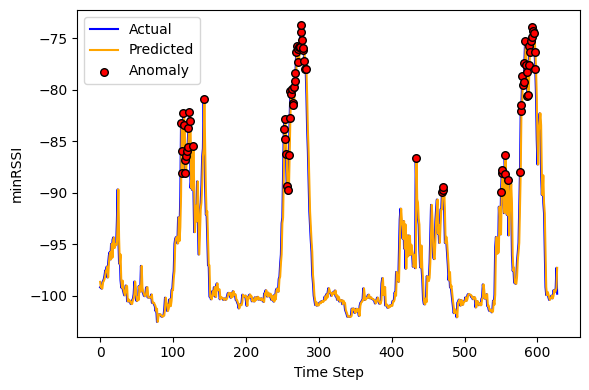

In [48]:
plot_predictions('test_preds_base.csv', sample_cell, 1)

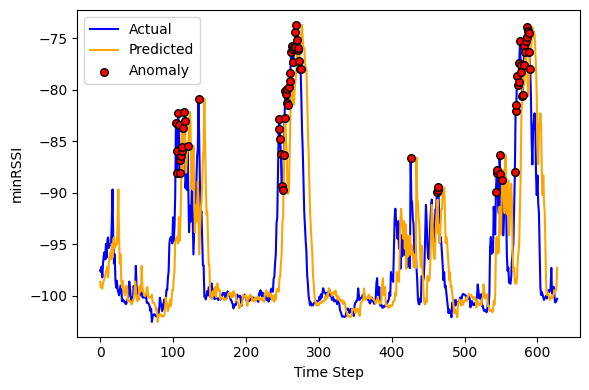

In [49]:
plot_predictions('test_preds_base.csv', sample_cell, 8)

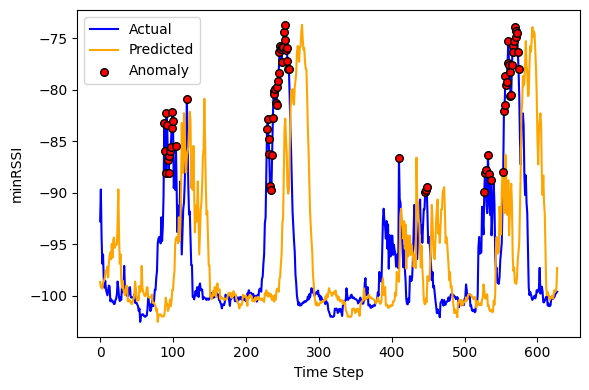

In [50]:
plot_predictions('test_preds_base.csv', sample_cell, 24)